In [1]:

%matplotlib inline
import pandas as pd
import numpy as np
from scipy import stats
from operator import itemgetter
import re
import json
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from google.colab import drive 
drive.mount('/content/gdrive') 

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:

def open_file(path):
  tweets = []
  with open(path) as file:
      for line in file: 
          if line.strip():
              tweets.append(json.loads(line))
  df = pd.json_normalize(tweets)
  df = df[["id","user.screen_name","user.id","retweeted_status.user.screen_name","retweeted_status.user.id_str"]]
  df = df.where(pd.notnull(df), None)
  df.sort_values("id", inplace = True) 
  df.drop_duplicates(subset ="id", keep = False, inplace = True)

  return df


In [ ]:
#!pip install --force-reinstall networkx==2.3

In [4]:
def add_edge(tweet):

    user = tweet["user.id"], tweet["user.screen_name"]
    
    if user[0] is None:
        return (None, None), []
    
    edge = set()
    edge.add((tweet["retweeted_status.user.id_str"], tweet["retweeted_status.user.screen_name"]))
    edge.discard((tweet["user.id"], tweet["user.screen_name"]))
    edge.discard((None, None))
    
    return user, edge

In [5]:

def make_graph(retweets):
  graph = nx.Graph()
  
  for index, tweet in retweets.iterrows():
    user, edge = add_edge(tweet)
    user_id, user_name = user
    tweet_id = tweet["id"]

    for x in edge:
        retweet_user_id, retweet_user_name = x
        graph.add_edge(user_id, retweet_user_id, tweet_id=tweet_id)
        graph.nodes[user_id]["name"] = user_name
        graph.nodes[retweet_user_id]["name"] = retweet_user_name

  return graph
  

In [6]:

def graph_feat(graph):

  if nx.is_connected(graph):
    print("The graph is connected")
  else:
    print("The graph is not connected")

  print(f"connected components in the Graph : {nx.number_connected_components(graph)} ")
  largest_subgraph = max(nx.connected_component_subgraphs(graph), key=len)
  print(f"Largest component have {largest_subgraph.number_of_nodes()} nodes and {largest_subgraph.number_of_edges()} edges ")
  
  return largest_subgraph

In [7]:

def centralities(largest_subgraph):

  graph_centrality = nx.degree_centrality(largest_subgraph)
  max_de = max(graph_centrality.items(), key=itemgetter(1))
  print(f"the node with id {max_de[0]} has a degree centrality of {max_de[1]:.2f} which is the maximum of the Graph")

  graph_closeness = nx.closeness_centrality(largest_subgraph)
  max_clo = max(graph_closeness.items(), key=itemgetter(1))
  print(f"the node with id {max_clo[0]} has a closeness centrality of {max_clo[1]:.2f} which is the maximum of the Graph")

  graph_betweenness = nx.betweenness_centrality(largest_subgraph, normalized=True, endpoints=False)
  max_bet = max(graph_betweenness.items(), key=itemgetter(1))
  print(f"the node with id {max_bet[0]} has a betweenness centrality of {max_bet[1]:.2f} which is the maximum of the Graph")
  
  return graph_centrality, graph_closeness, graph_betweenness
 

In [8]:
df_sush = open_file('/content/gdrive/My Drive/Flickr8kData/twitter_sushant.json')
df_sush

,id,user.screen_name,user.id,retweeted_status.user.screen_name,retweeted_status.user.id_str
0,1285202721663062016,BhuniaRinku,3715278613,mudibhatnagar15,3260908854
1,1285202724187803649,SGFCSL,1032291961405730816,MukeshChhabraCC,2549731028
2,1285202751811543046,Akansha63361787,1208824896215633920,None,None
3,1285202798687121408,Madhavi18681260,1273273022665773056,CastingChhabra,613696125
4,1285202809487454213,SRKzKaali,1244220345957089281,CastingChhabra,613696125
...,...,...,...,...,...
17884,1285736525834133504,salmansAvider,1209304044390367232,SuperADianNJ,2693625568
17885,1285736534923255810,Lerahkop_1,2573310966,SushantNMehta,34216035
17886,1285736561523462149,itweetosr,1276792219601494021,Apurvasrani,141509593
17887,1285736562479652864,PujaVaishya,1258504440954277888,Tweet2TBG,440072843


In [9]:

print("sush tweets graph")

t_graph = make_graph(df_sush)
largest_subgraph_s = graph_feat(t_graph)

print("Calculating centralities")
graph_centrality, graph_closeness, graph_betweenness = centralities(largest_subgraph_s)

print("------graph_centrality-------")
print(graph_centrality)

print("-----graph_closeness-----")
print(graph_closeness)

print("-----graph_betweenness-------")
print(graph_betweenness)


sush tweets graph
The graph is not connected
connected components in the Graph : 344 
Largest component have 7751 nodes and 11908 edges 
Calculating centralities
the node with id 3946905252 has a degree centrality of 0.10 which is the maximum of the Graph
the node with id 906812915499417600 has a closeness centrality of 0.34 which is the maximum of the Graph
the node with id 3946905252 has a betweenness centrality of 0.22 which is the maximum of the Graph
------graph_centrality-------
{1032291961405730816: 0.00012903225806451613, '2549731028': 0.003612903225806452, 1273273022665773056: 0.00012903225806451613, '613696125': 0.07109677419354839, 1244220345957089281: 0.00012903225806451613, 914493255278104576: 0.00012903225806451613, 1721012234: 0.00012903225806451613, 1714590241: 0.00012903225806451613, '1064407129568636928': 0.002838709677419355, 1275709911452782594: 0.00012903225806451613, '636101893': 0.001032258064516129, 1266395262811062277: 0.00012903225806451613, 102654827976770764

In [11]:

def draw_largest_subgraph(largest_subgraph, nodes, central_nodes):

  node_and_degree = largest_subgraph.degree()
  colors_central_nodes = ['orange','red']
  

  #largest_subgraph = sorted(connected_component_subgraphs(graph), key=len, reverse=True)[0]
  pos = nx.spring_layout(largest_subgraph, k=0.05)
  plt.figure(figsize = (20,20))
  nx.draw(largest_subgraph, pos=pos, node_color=range(nodes), cmap=plt.cm.PiYG, edge_color="black", linewidths=0.3, node_size=60, alpha=0.6, with_labels=False)
  nx.draw_networkx_nodes(largest_subgraph, pos=pos, nodelist=central_nodes, node_size=300, node_color=colors_central_nodes)
  plt.savefig('graphfinal.png')
  plt.show()


/usr/local/lib/python3.6/dist-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


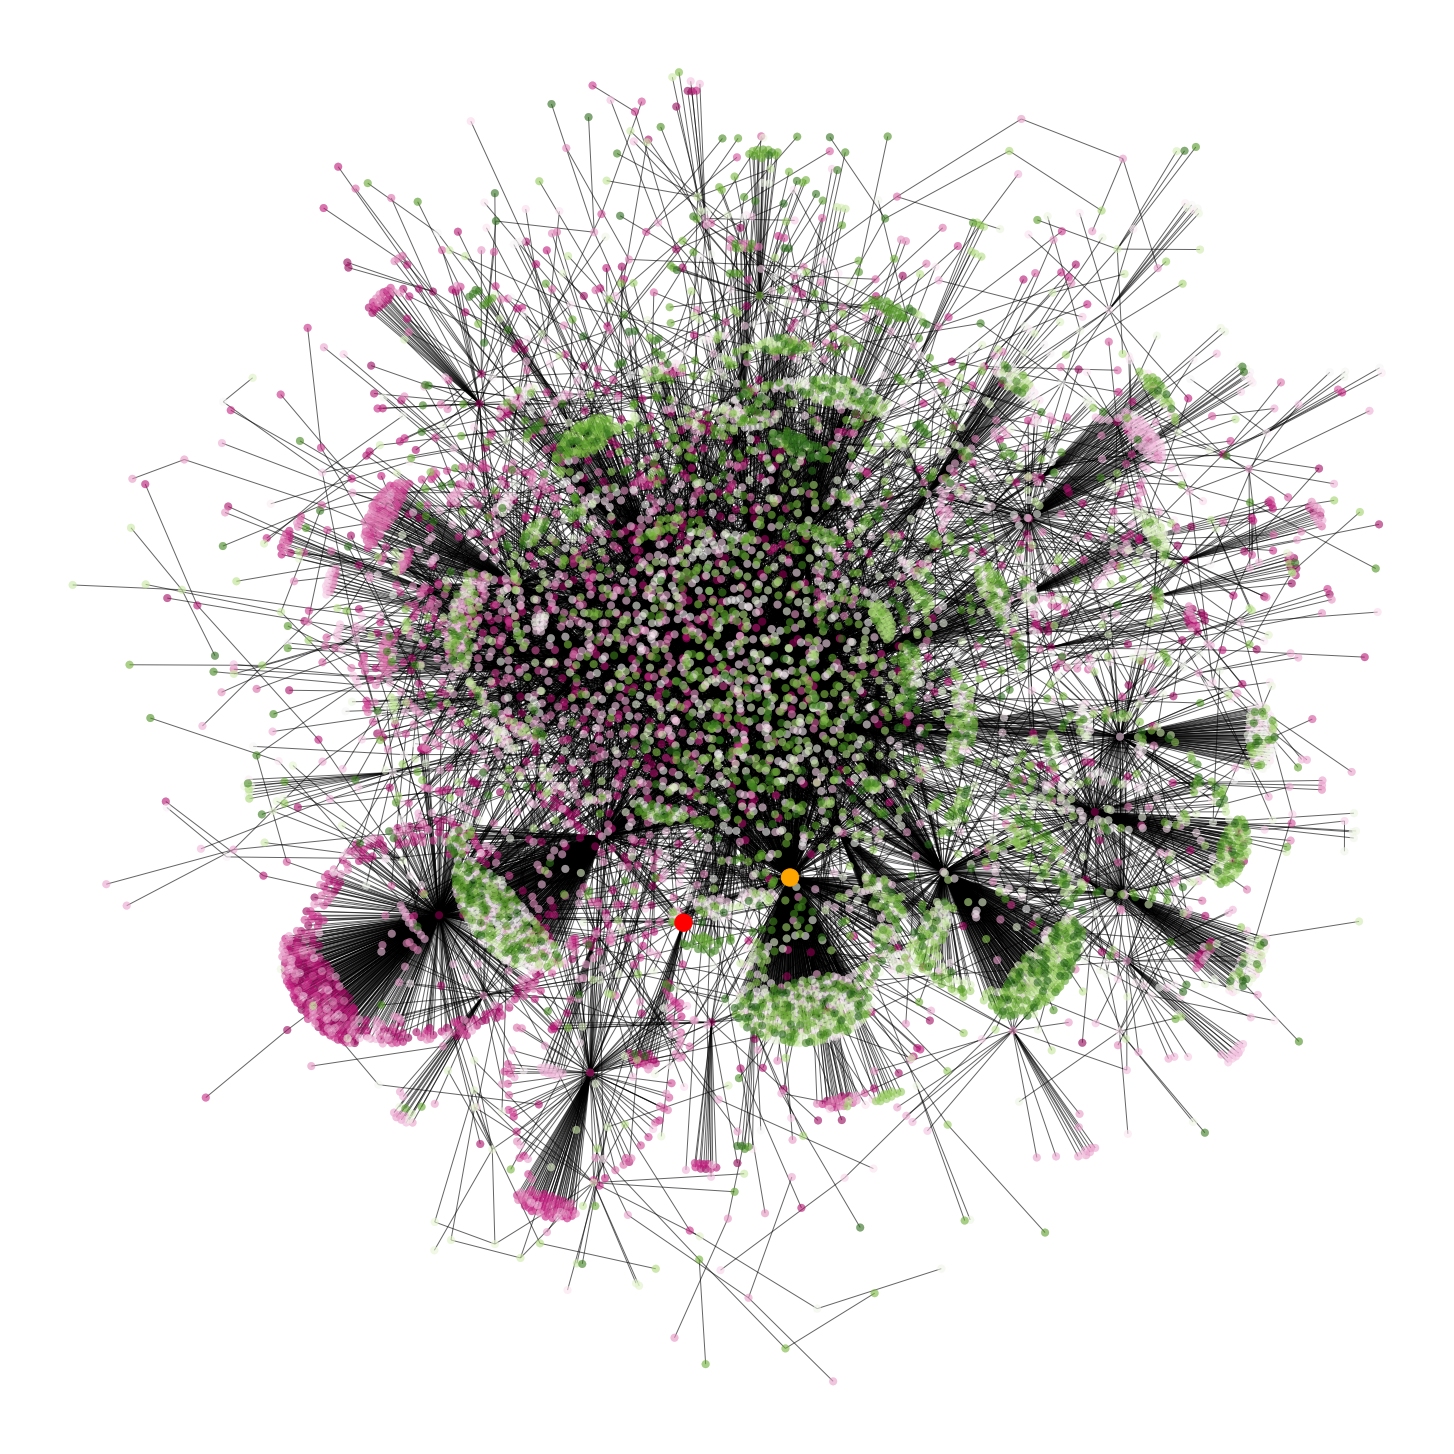

In [15]:
draw_largest_subgraph(largest_subgraph_s, 7751, ['3946905252','1090513571581091840'])

/usr/local/lib/python3.6/dist-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


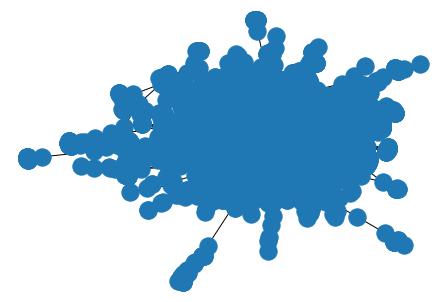

<Figure size 1440x1440 with 0 Axes>

In [16]:
nx.draw(largest_subgraph_s) 
plt.figure(figsize = (20,20))
plt.savefig("filename.png") 
plt.show()

In [22]:
def smallest_graph_feat(graph):

  smallest_subgraph = min(nx.connected_component_subgraphs(graph), key=len)
  print(f"smallest component have {smallest_subgraph.number_of_nodes()} nodes and {smallest_subgraph.number_of_edges()} edges ")
  
  return smallest_subgraph

In [23]:
smallest_subgraph_s = smallest_graph_feat(t_graph)

print("Calculating centralities")
graph_centrality, graph_closeness, graph_betweenness = centralities(smallest_subgraph_s)

print("------graph_centrality-------")
print(graph_centrality)

print("-----graph_closeness-----")
print(graph_closeness)

print("-----graph_betweenness-------")
print(graph_betweenness)


smallest component have 2 nodes and 1 edges 
Calculating centralities
the node with id 3715278613 has a degree centrality of 1.00 which is the maximum of the Graph
the node with id 3715278613 has a closeness centrality of 1.00 which is the maximum of the Graph
the node with id 3715278613 has a betweenness centrality of 0.00 which is the maximum of the Graph
------graph_centrality-------
{3715278613: 1.0, '3260908854': 1.0}
-----graph_closeness-----
{3715278613: 1.0, '3260908854': 1.0}
-----graph_betweenness-------
{3715278613: 0.0, '3260908854': 0.0}
